# General tests of te AIS

Created on Tue Nov 22 16h24m,  2022

This is a script for the development of general tests

@author: denis


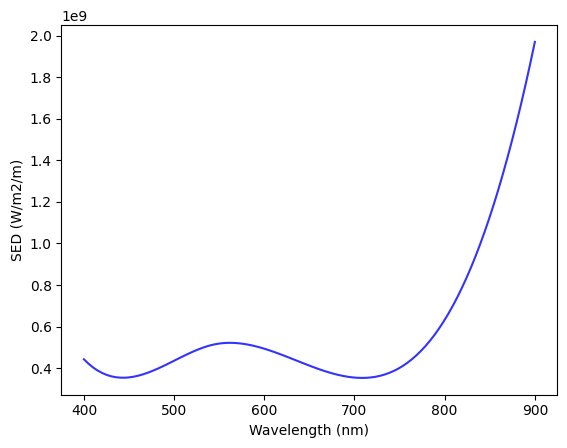

In [14]:
# Test sky SED
from AIS.Spectral_Energy_Distribution import Sky
import matplotlib.pyplot as plt
import numpy as np

wv = np.linspace(400, 900, 100)
sky = Sky()
sky_sed = sky.calculate_sed('new', wv)
plt.plot(wv, sky_sed, 'b', alpha=0.8)
plt.xlabel('Wavelength (nm)')
plt.ylabel('SED (photons/m2/m)')
plt.show()

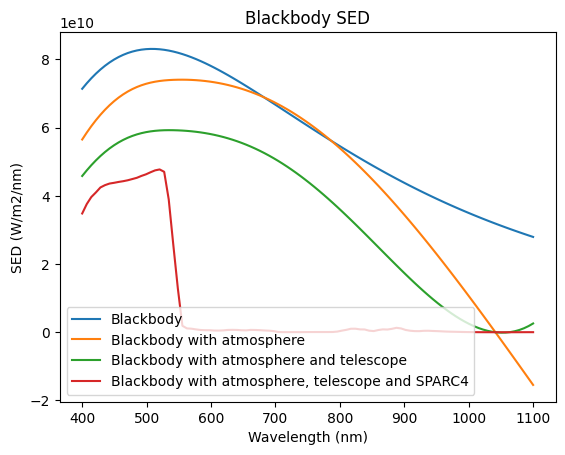

In [2]:
# Test the blackbody profile
from AIS. Artificial_Image_Simulator import Artificial_Image_Simulator
from AIS.Spectral_Energy_Distribution import Source
import matplotlib.pyplot as plt
ccd_operation_mode = {
    'em_mode': 'Conv',
    'em_gain': 1,
    'preamp': 1,
    'readout': 1,
    'binn': 1,
    't_exp': 1,
    'image_size': 100
}

ais = Artificial_Image_Simulator(ccd_operation_mode, 1, -70)

ais.create_source_sed('blackbody', 15, (400, 1100, 100), 5700)
ais.create_sky_sed('new')
plt.plot(ais.wavelength, ais.source_sed, label='Blackbody')
ais.apply_atmosphere_spectral_response()
plt.plot(ais.wavelength, ais.source_sed, label='Blackbody with atmosphere')
ais.apply_telescope_spectral_response()
plt.plot(ais.wavelength, ais.source_sed,
         label='Blackbody with atmosphere and telescope')
ais.apply_sparc4_spectral_response('photometry')
plt.plot(ais.wavelength, ais.source_sed,
         label='Blackbody with atmosphere, telescope and SPARC4')
plt.legend()
plt.xlabel('Wavelength (nm)')
plt.ylabel('SED (photons/m2/nm)')
plt.title('Blackbody SED')
plt.show()

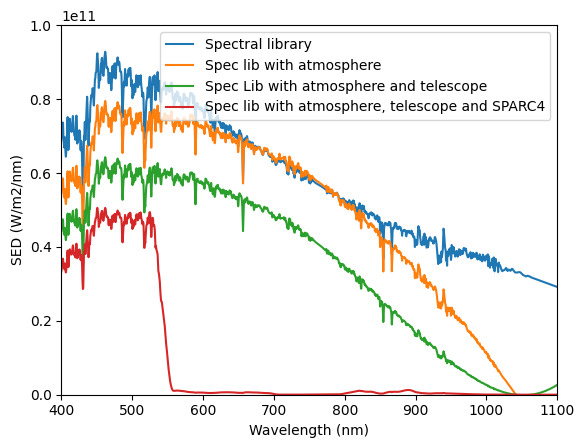

In [22]:
# Test the _read_spectral_library function
from AIS. Artificial_Image_Simulator import Artificial_Image_Simulator
from AIS.Spectral_Energy_Distribution import Source
import matplotlib.pyplot as plt
ccd_operation_mode = {
    'em_mode': 'Conv',
    'em_gain': 1,
    'preamp': 1,
    'readout': 1,
    'binn': 1,
    't_exp': 1,
    'image_size': 100
}

ais = Artificial_Image_Simulator(ccd_operation_mode, 1, -70)

ais.create_source_sed('spectral_library', 15, (400, 1100, 100), spectral_type='g5v')
ais.create_sky_sed('new')
plt.plot(ais.wavelength, ais.source_sed, label='Spectral library')
ais.apply_atmosphere_spectral_response()
plt.plot(ais.wavelength, ais.source_sed, label='Spec lib with atmosphere')
ais.apply_telescope_spectral_response()
plt.plot(ais.wavelength, ais.source_sed,
         label='Spec Lib with atmosphere and telescope')
ais.apply_sparc4_spectral_response('photometry')
plt.plot(ais.wavelength, ais.source_sed,
         label='Spec lib with atmosphere, telescope and SPARC4')
plt.legend()
plt.xlabel('Wavelength (nm)')
plt.ylabel('SED (photons/m2/nm)')
plt.xlim(400, 1100)
plt.ylim(0, 1e11)
plt.show()

In [3]:
# Test the sbpy package
from sbpy.calib import Vega, vega_fluxd
print(vega_fluxd.get()["Johnson V"].value)


3.62701e-09


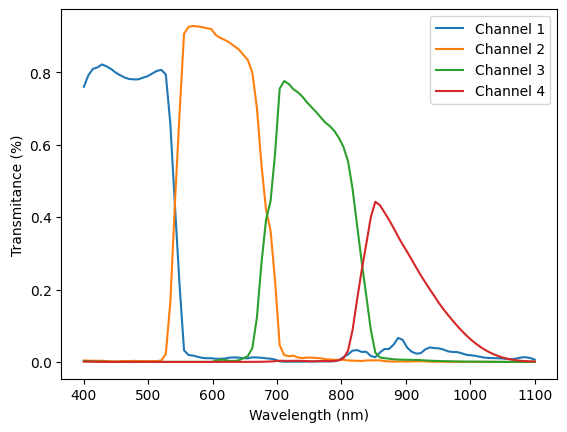

In [11]:

# Test the sparc4 spectral response
from AIS.Spectral_Response import Channel
import matplotlib.pyplot as plt
import numpy as np

sed = np.ones(100)
wv = np.linspace(400, 1100, 100)
for i in [1, 2, 3, 4]:
    channel = Channel(i)
    channel.write_sparc4_operation_mode('photometry')
    ch1_spectral_response = channel.apply_spectral_response(sed, wv)
    plt.plot(wv, ch1_spectral_response, label=f'Channel {i}')
plt.legend()
plt.xlabel('Wavelength (nm)')
plt.ylabel('Transmitance (%)')
plt.show()


In [ ]:

# Test the atmosphere spectral response
from AIS.Spectral_Response import Atmosphere
import matplotlib.pyplot as plt
import numpy as np

obj_wavelength = np.arange(400, 1100, 100)
atmosphere = Atmosphere()
spectral_response = atmosphere.get_spectral_response(obj_wavelength, 1)
plt.plot(obj_wavelength, spectral_response)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Transmitance (%)')
plt.show()


In [ ]:
# Test telescope spectral response
from AIS.Spectral_Response import Telescope
import numpy as np

obj_wavelength = np.arange(400, 1100, 100)
telescope = Telescope()
spectral_response = telescope.get_spectral_response(obj_wavelength)
plt.plot(obj_wavelength, spectral_response)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Transmitance (%)')
plt.show()


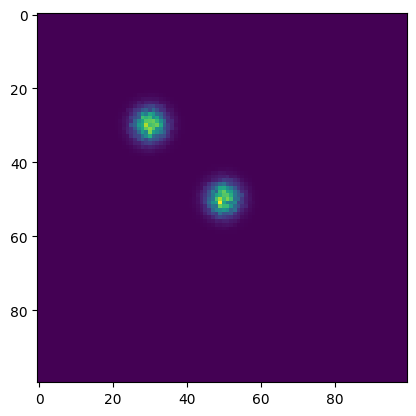

In [2]:
# Test the PSF class
from AIS.Point_Spread_Function import Point_Spread_Function
import matplotlib.pyplot as plt
ccd_operation_mode = {
    'em_mode': 'Conv',
    'em_gain': 1,
    'preamp': 1,
    'readout': 1,
    'binn': 1,
    't_exp': 1,
    'image_size': 100
}
psf = Point_Spread_Function(ccd_operation_mode, 1)
image = psf.create_star_image((50, 50), 1e3, 1e3)
plt.imshow(image)
plt.show()

In [1]:
# Test the AIS.create_image function
from AIS.Artificial_Image_Simulator import Artificial_Image_Simulator
import matplotlib.pyplot as plt

wavelegnth_interval = (400, 1100, 100)
ais = Artificial_Image_Simulator(ccd_operation_mode, 1, -70)
ais.create_source_sed('blackbody', 15, wavelegnth_interval, 5700)
ais.create_sky_sed('new')
ais.apply_atmosphere_spectral_response(air_mass=1.2, sky_condition='photometric')
ais.apply_telescope_spectral_response()
ais.apply_sparc4_spectral_response('photometry')
ais.create_artificial_image(r'E:\images\test', (50, 50))